# Parameter identification using PINNs

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
import scipy
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [ ]:
pi = np.pi

# The transport equation

We illustrate the functionning of the model using the transport equation:

$$ u_t + c u_x = 0, \qquad  (x, t)\in [- \infty,\infty]\times [0, 1] $$
with initial condition
$$u(x, 0) = g(x).$$

In [ ]:
pi = np.pi

In [ ]:
tmax = 1
L = 2
c_star = 3.

We use the exact solution $u(x,t) = g(x-ct)$ to generate the data points we'll need to learn the parameter $c$.

In [ ]:
def g_func(x):
    return np.sin(pi*x)

def transport_sol(z):
    return g_func(z[:,0:1] - z[:,1:2]*c_star)

# define a function that generates data to learn the parameters
def params_data(nbr_pts=100):
    """
    nbr_pts: number of points to use
    """
    x = np.random.uniform(-L, L, nbr_pts)
    t = np.random.uniform(0, tmax, nbr_pts)
    z = np.stack([x, t], 1)
    param_data = g_func(z[:,0:1] - z[:,1:2]*c_star)
    return z, param_data

The initial and the residues data.

In [ ]:
# initial condition
def transport_ic(X):
  # X = (x, t)
    return tf.sin(pi * X[:,0:1])

# the pde
def transport_int(u, u_t, u_x):
    return (u_t + c * u_x)**2

The derivatives we'll need:

In [ ]:
def get_derivatives(model, X):

    with tf.GradientTape(persistent=True) as tape:

        x = X[:,0:1]
        t = X[:,1:2]
        tape.watch(x)
        tape.watch(t)
        u = model(tf.concat([x, t], -1))

        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
    del tape

    return u, u_t, u_x

The loss of the model with its gradient:

In [ ]:
# The line below creates z_params which are (x,t) of the sampled points,
# and u_params which are the real value of the solution at this point.
z_params, u_params = params_data(100)

def loss_fn(model, X_int, X_ic):
    loss_ic =  tf.reduce_mean((transport_ic(X_ic) - model(X_ic))**2)

    u, u_t, u_x = get_derivatives(model, X_int)

    res = transport_int(u, u_t, u_x)
    loss_res = tf.reduce_mean(res)
    #This loss computes the difference between predicted u from the model and true values
    loss_para = tf.reduce_mean((model(z_params) - u_params)**2)

    return loss_res + loss_ic + loss_para

In [ ]:
def loss_grad(model, X_int, X_ic):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = loss_fn(model, X_int, X_ic)
    #These are gradients with respect to the weights and parameters
    grad_theta = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, grad_theta

A function that generates a batch for data points during the training. We need interior points and other points for the initial condition.

In [ ]:
def batch_generator(ic_batch_size=20, int_batch_size=100):
    # randomly generate the training points
    #================================
    #points for the initial condition
    #================================
    X_ic0 = tf.random.uniform((ic_batch_size, 1), -L, L)
    X_ic1 = tf.zeros((ic_batch_size, 1))
    X_ic = tf.concat([X_ic0, X_ic1], -1)
    #====================
    #the interior points
    #====================
    X_int0 = tf.random.uniform((int_batch_size,1),-L, L)
    X_int1 = tf.random.uniform((int_batch_size,1), 0., tmax)
    X_int = tf.concat([X_int0, X_int1], -1)
    return X_ic, X_int

A class that defines the model we'll use throughout the notebook.

In [ ]:
class PINN_model(keras.Model):
    def __init__(self,
            output_dim=1,
            num_layers=4,
            size_layer=64,
            activation="tanh",
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.output_dim = output_dim

        # Define NN architecture
        self.hidden = [Dense(size_layer,
                             activation=activation,
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_layers)]
        self.out = Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        for i in range(self.num_layers):
            X = self.hidden[i](X)
        return self.out(X)

A subclass of the previous class that implements a model that is specific to the problem:

In [ ]:
#Starting guess for the parameter; remember that the real value is c_star = 3
c = tf.Variable(2.)

class transport_PINN(PINN_model):
    def __init__(self, parameter, **kwargs):
        super().__init__(**kwargs)
        #This line below defines the parameter to be identified which is c
        self.parameter = parameter

model = transport_PINN(
    parameter=c,
    num_layers=4,
    size_layer=64,
    activation=tf.keras.activations.get(tf.math.sin),
    )

model.build(input_shape=(None,2))

In [ ]:
def train_step(model, X_int, X_ic):
    # Compute current loss and gradient wrt parameters
    loss, grad_theta = loss_grad(model, X_int, X_ic)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

Epoch: 0  out of 10000  loss: 1.2945035
Epoch: 500  out of 10000  loss: 0.3931265
Epoch: 1000  out of 10000  loss: 0.1011888
Epoch: 1500  out of 10000  loss: 0.0082559325
Epoch: 2000  out of 10000  loss: 0.00033235448
Epoch: 2500  out of 10000  loss: 0.000116241135
Epoch: 3000  out of 10000  loss: 0.00010523709
Epoch: 3500  out of 10000  loss: 0.00041769564
Epoch: 4000  out of 10000  loss: 4.2655076e-05
Epoch: 4500  out of 10000  loss: 5.665471e-05
Epoch: 5000  out of 10000  loss: 0.00020207523
Epoch: 5500  out of 10000  loss: 0.000112889255
Epoch: 6000  out of 10000  loss: 9.211524e-05
Epoch: 6500  out of 10000  loss: 0.00085951923
Epoch: 7000  out of 10000  loss: 9.8917095e-05
Epoch: 7500  out of 10000  loss: 0.0008900643
Epoch: 8000  out of 10000  loss: 4.224204e-05
Epoch: 8500  out of 10000  loss: 0.000928691
Epoch: 9000  out of 10000  loss: 0.00018384957
Epoch: 9500  out of 10000  loss: 0.0021049576

 The loss is: 0.000445347250206396


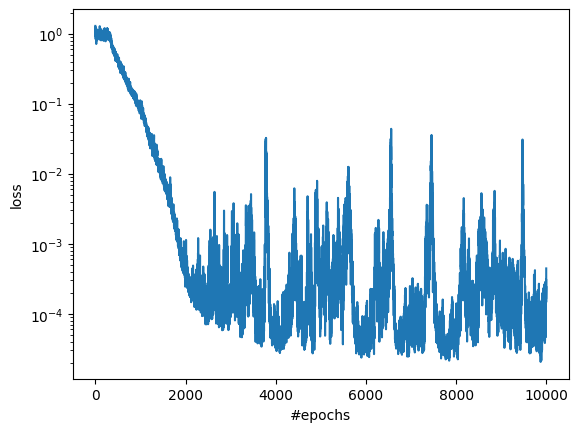

In [ ]:
# Number of training epochs
N = 10000

# learning rate
learning_rate = 1e-3

optim = keras.optimizers.Adam(learning_rate=learning_rate)
@tf.function


hist = []
for i in range(N):
    X_ic, X_int = batch_generator()
    loss = train_step(model, X_int, X_ic)
    # Append current loss to hist
    hist.append(loss.numpy())

    if i%500 == 0:
      print("Epoch:", i, " out of", N, " loss:", loss.numpy())

# Print the loss
print('\n The loss is: {}'.format(hist[-1]))
# Print computation time

# Print the learning curve
plt.semilogy(range(len(hist)), np.array(hist).flatten())
plt.xlabel('#epochs')
plt.ylabel('loss');

The learned parameter is stored in `model.parameter`. Recall that the true value is $c^*=3$.

In [ ]:
#The parameter in the model is c
print('The found value of c is:',model.parameter.numpy(),' True value:',c_star)

The found value of c is: 1.114539  True value: 3.0


We can also compare the predicted function to the exact value.

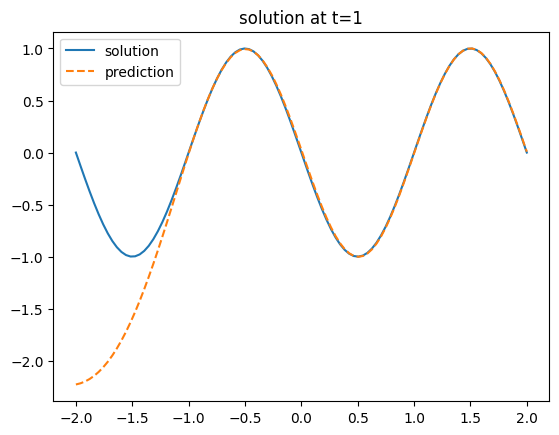

In [ ]:
X = np.stack([np.linspace(-L, L, 100), [1]*100], 1)
plt.plot(np.linspace(-L, L, 100), transport_sol(X), label="solution")
plt.plot(np.linspace(-L, L, 100), model(X), "--", label="prediction")
plt.legend()
plt.title("solution at t=1")
plt.show()

# Inviscid Burgers' equation

In this example we consider the inviscid Burgers' equation $$
u_t + uu_x = 0 $$
with the initial condition $$u\left(x,0\right) = ax+b. $$
Its exact solution is $$u(x,t)=\frac{ax+b}{at +1}.$$

In [ ]:
a_star = 2.
b_star = 3.

# half the integration interval
L = 2.
tmax = 1

The learnable variables:

In [ ]:
a = tf.Variable(1.)
b = tf.Variable(2.)

We use the exact solution to generate points for finding the parameters $a$ and $b$.

In [ ]:
def inviscid_sol(z):
    return (a_star*z[:,0:1] + b_star) / (a_star*z[:,1:2] + 1)

def params_data(nbr_pts=100):
    x = np.random.uniform(-L, L, [nbr_pts, 1])
    t = np.random.uniform(0, tmax, [nbr_pts, 1])
    z = np.hstack((x, t))
    return z, inviscid_sol(z)

As before, we compute the derivatives, the loss and its gradient.

In [ ]:
# initial condition
def inviscid_ic(X):
  # X = (x, t)
    return a * X[:,0:1] + b

# the pde
def inviscid_int(u, u_t, u_x):
    return (u_t + u * u_x)**2

In [ ]:
def get_derivatives(model, X):

    with tf.GradientTape(persistent=True) as tape:

        x = X[:,0:1]
        t = X[:,1:2]
        tape.watch(x)
        tape.watch(t)
        u = model(tf.concat([x, t], -1))

        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
    del tape

    return u, u_t, u_x

In [ ]:
z_params, u_params = params_data()

def loss_fn(model, X_int, X_ic):
    loss_ic =  tf.reduce_mean((inviscid_ic(X_ic) - model(X_ic))**2)

    u, u_t, u_x = get_derivatives(model, X_int)
    res = inviscid_int(u, u_t, u_x)
    loss_res = tf.reduce_mean(res)

    loss_param = tf.reduce_mean((model(z_params) - u_params)**2)

    return loss_res + loss_ic + loss_param

In [ ]:
def loss_grad(model, X_int, X_ic):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = loss_fn(model, X_int, X_ic)

    grad_theta = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, grad_theta

In [ ]:
def batch_generator(ic_batch_size=16, int_batch_size=64):
    # randomly generate the training points
    X_ic0 = tf.random.uniform((ic_batch_size, 1), -L, L)
    X_ic1 = tf.zeros((ic_batch_size, 1))
    X_ic = tf.concat([X_ic0, X_ic1], -1)
    #====================================================
    X_int0 = tf.random.uniform((int_batch_size,1), -L, L)
    X_int1 = tf.random.uniform((int_batch_size,1), 0., tmax)
    X_int = tf.concat([X_int0, X_int1], -1)
    return X_int, X_ic

We define the model. The parameters are stored in `model.parameters`:

In [ ]:
class Burgers_inviscid(PINN_model):
    def __init__(self, parameters, **kwargs):
        super().__init__(**kwargs)
        self.parameters = parameters

model = Burgers_inviscid(parameters=[a, b])
model.build(input_shape=(None,2))

loss is: 12.678501
loss is: 0.49960378
loss is: 0.08936457
loss is: 0.051078305
loss is: 0.036352746
loss is: 0.040775925
loss is: 0.036006227
loss is: 0.034920096
loss is: 0.032797415
loss is: 0.027953938
loss is: 0.026107986
loss is: 0.02276689
loss is: 0.018981747
loss is: 0.01496762
loss is: 0.013794886
loss is: 0.009990851
loss is: 0.007072123
loss is: 0.0047015296
loss is: 0.003508038
loss is: 0.0022959244
loss is: 0.0014463814
loss is: 0.0009464794
loss is: 0.00043295394
loss is: 0.00031389497
loss is: 0.00014664797
loss is: 8.054811e-05
loss is: 4.599499e-05
loss is: 2.9264584e-05
loss is: 3.1347194e-05
loss is: 2.55713e-05
loss is: 3.771507e-05
loss is: 0.000101797574
loss is: 3.2688116e-05
loss is: 9.7383445e-06
loss is: 1.9071722e-05
loss is: 3.9965584e-05
loss is: 2.843364e-05
loss is: 7.771115e-06
loss is: 7.309926e-05
loss is: 2.5377924e-05

 The loss is: 1.5897998309810646e-05


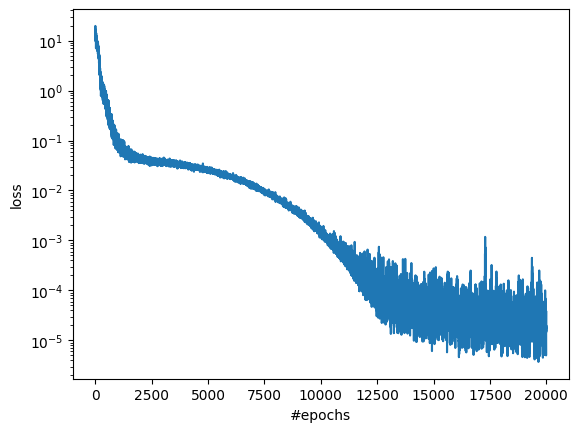

In [ ]:
# Number of training epochs
N = 20000
# learning rate
learning_rate = 1e-4

optim = keras.optimizers.Adam(learning_rate=learning_rate)
@tf.function
def train_step(model, X_int, X_ic):
    # Compute current loss and gradient wrt parameters
    loss, grad_theta = loss_grad(model, X_int, X_ic)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

hist = []
for i in range(N):
    X_int, X_ic = batch_generator()
    loss = train_step(model, X_int, X_ic)

    # Append current loss to hist
    hist.append(loss.numpy())

    if i%500 == 0:
      print("loss is:", loss.numpy())

# Print the loss
print('\n The loss is: {}'.format(hist[-1]))
# Print computation time

# Print the learning curve
plt.semilogy(range(len(hist)), np.array(hist).flatten())
plt.xlabel('#epochs')
plt.ylabel('loss');

The true values of $a$ and $b$ are $2$ and $3$. The predicted values are:

In [ ]:
print("a is: {}\nb is: {}".format(model.parameters[0].numpy(),model.parameters[1].numpy()))

a is: 1.9999417066574097
b is: 2.9999947547912598


# Viscous Burgers' equation

We consider $1$-dimensional Burgers' equation
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \qquad x\in [-1,1],\; t\in [0,1]  
$$
with the Dirichlet boundary conditions and initial conditions
$$
u(-1,t)=u(1,t)=0\quad \text{and}\quad u(x,0)=-\sin(\pi x).
$$

In [ ]:
tmax = 1
L = 1

In [ ]:
nu_star = 0.1

nu = tf.Variable(1.)

In [ ]:
# initial condition
def burg_ic(X):
  # X = (x, t)
    return -tf.sin(pi * X[:,0:1])

# boundary condition
def burg_bc(X):
  # X = (x, t)
    return tf.zeros((X.shape[0],1))

# the pde
def burg_int(u, u_t, u_x, u_xx):
    return (u_t + u * u_x - nu * u_xx)**2

Data points obtained using a numerical solution.

In [ ]:
nx = 1000
dx = 2*L / nx

# Define the time domain
tmax = tmax
nt = 400
dt = tmax / nt

# Define the initial condition function
def initial_condition(x):
    return -np.sin(np.pi * x)

# Create arrays for the spatial and temporal grids
x = np.linspace(-L, L, nx)
u0 = initial_condition(x)

# Define the Burgers' equation with the boundary conditions
def burgers_equation(u, t):
    dudt = np.zeros_like(u)
    dudt[1:-1] = -u[1:-1] * (u[2:] - u[:-2]) / (2 * dx) + nu_star * (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    dudt[0] = 0
    dudt[-1] = 0
    return dudt

u_solution = odeint(burgers_equation, u0, np.linspace(0, tmax, nt))

A function to generate `nbr_pts` number of points from the numerical solution to use for the purpose of finding $\nu$.

In [ ]:
def params_data(nbr_pts=100):
    t = np.linspace(0, tmax, nt)
    x_pts, t_pts = np.meshgrid(x, t)
    X = np.stack([x_pts.flatten(), t_pts.flatten()], 1)
    # we flatten the solution array to that the image of X[i] is U[i]
    U = u_solution.reshape(400000, 1)
    # we randomly sample indices in [0, nt*nx - 1] so that the image of X[index] is U[index]
    index = np.random.randint(0, 399999, nbr_pts)
    return X[index], U[index]

In [ ]:
def get_derivatives(model, X):

    with tf.GradientTape(persistent=True) as tape:

        x = X[:,0:1]
        t = X[:,1:2]
        tape.watch(x)
        tape.watch(t)
        u = model(tf.concat([x, t], -1))

        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)

    u_xx = tape.gradient(u_x, x)

    del tape

    return u, u_x, u_xx, u_t

In [ ]:
z_params, u_params = params_data()

def loss_fn(model, X_int, X_ic, X_bc):
    loss_ic =  tf.reduce_mean((burg_ic(X_ic) - model(X_ic))**2)
    loss_bc = tf.reduce_mean((burg_bc(X_bc) - model(X_bc))**2)

    u, u_x, u_xx, u_t = get_derivatives(model, X_int)
    res = burg_int(u, u_t, u_x, u_xx)
    loss_res = tf.reduce_mean(res)

    loss_param = tf.reduce_mean((model(z_params)-u_params)**2)

    return loss_res + loss_ic + loss_bc + loss_param

In [ ]:
def loss_grad(model, X_int, X_ic, X_bc):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = loss_fn(model, X_int, X_ic, X_bc)

    grad_theta = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, grad_theta

A function the generates three sets of points for the initial condition, the boundary condition and for the residue.

In [ ]:
def batch_generator(ic_batch_size=16, int_batch_size=64, bc_batch_size=32):
    #==================================
    #points for the initial condition
    #==================================
    X_ic0 = tf.random.uniform((ic_batch_size, 1), -L, L)
    X_ic1 = tf.zeros((ic_batch_size, tmax))
    X_ic = tf.concat([X_ic0, X_ic1], -1)
    #==================================
    #points for the boundary condition
    #==================================
    X_bc0 = tf.random.uniform((bc_batch_size, 1), 0, 2, dtype=tf.int32) * 2 - 1
    X_bc0 = tf.cast(X_bc0, tf.float32) * L
    X_bc1 = tf.random.uniform((bc_batch_size, 1), 0, tmax)
    X_bc = tf.concat([X_bc0, X_bc1], -1)
    #==================================
    #interior points
    #==================================
    X_int0 = tf.random.uniform((int_batch_size,1), -L, L)
    X_int1 = tf.random.uniform((int_batch_size,1), 0., tmax)
    X_int = tf.concat([X_int0, X_int1], -1)
    return X_int, X_ic, X_bc

In [ ]:
class Burgers_viscous(PINN_model):
    def __init__(self, parameter, **kwargs):
        super().__init__(**kwargs)
        self.parameter = parameter

model = Burgers_viscous(parameter=nu, num_layers=3, size_layer=32)
model.build(input_shape=(None,2))

Epoch: 0 Loss: 0.6628257036209106
Epoch: 500 Loss: 0.5375142097473145
Epoch: 1000 Loss: 0.3536927402019501
Epoch: 1500 Loss: 0.3268664479255676
Epoch: 2000 Loss: 0.27819469571113586
Epoch: 2500 Loss: 0.20993821322917938
Epoch: 3000 Loss: 0.15245148539543152
Epoch: 3500 Loss: 0.10484481602907181
Epoch: 4000 Loss: 0.08644906431436539
Epoch: 4500 Loss: 0.07583943754434586
Epoch: 5000 Loss: 0.06304030120372772
Epoch: 5500 Loss: 0.05672772228717804
Epoch: 6000 Loss: 0.052142299711704254
Epoch: 6500 Loss: 0.04306087642908096
Epoch: 7000 Loss: 0.03484336659312248
Epoch: 7500 Loss: 0.028266780078411102
Epoch: 8000 Loss: 0.02521844208240509
Epoch: 8500 Loss: 0.024325717240571976
Epoch: 9000 Loss: 0.025421053171157837
Epoch: 9500 Loss: 0.022492511197924614
Epoch: 10000 Loss: 0.02277405932545662
Epoch: 10500 Loss: 0.02280866913497448
Epoch: 11000 Loss: 0.029375286772847176
Epoch: 11500 Loss: 0.019214922562241554
Epoch: 12000 Loss: 0.019744539633393288
Epoch: 12500 Loss: 0.020284302532672882
Epoch

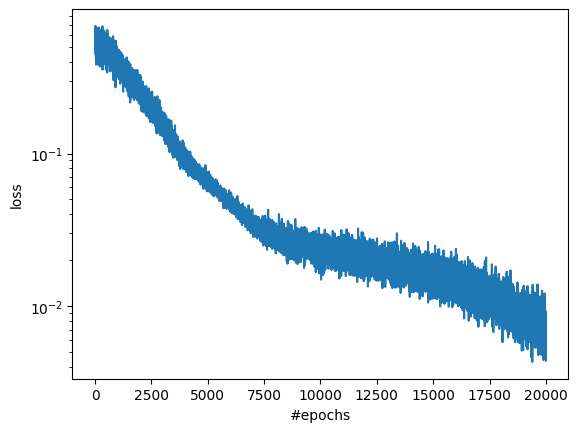

In [ ]:
# Number of training epochs
N = 20000
# learning rate
learning_rate = 1e-4

optim = keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(model, X_int, X_ic, X_bc):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = loss_grad(model, X_int, X_ic, X_bc)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

hist = []
for i in range(N):
    X_int, X_ic, X_bc = batch_generator()
    loss = train_step(model, X_int, X_ic, X_bc)

    # Append current loss to hist
    hist.append(loss.numpy())

    if i%500 == 0:
      print("Epoch:",i,'Loss: {}'.format(hist[-1]))

# Print the loss
print("Epoch:",i,'Loss: {}'.format(hist[-1]))

# Print the learning curve
plt.semilogy(range(len(hist)), np.array(hist).flatten())
plt.xlabel('#epochs')
plt.ylabel('loss');

The true value of $\nu$ is $0.1$, we get a value of

In [ ]:
print('Found value of nu is:',model.parameter.numpy())

Found value of nu is: 0.10944381


# Logistic equation

In this example we employ the second approch to the problem of parameter determination. As a first example, we consider the logistic equation $$ u_t = ru\left(1- ku\right),$$
with two parameters $r$ and $k$ which we try to determine.

We use an alternative method, where we add an additional equation
$$ u_t = ru\left(1- ku\right),\quad r_t =0 \, , \quad k_t =0 $$
with some initial conditions for $(u(0),r(0),k(0))$. From the last equation, $k=$const, but the equation will give $k$ to be approximately constant.


The exact solution of the logistics equation, with initial value $u(0)$ and $r=r(0)$ and $k=k(0)$, is
$$u(t) = \frac{1}{k + \left( \frac{1 - ku(0)}{u(0)}\right)e^{-rt}}.$$ We will use that solution to generate the data points and determine $k$.

In [ ]:
# parameters of the problem
r_star = 1
k_star = 3
tmax = 10
u0 = 1.

We use the exact solution to generate  data points for learning the parameter $k$.

In [ ]:
def params_data_logistic(nbr_pts=100):
    t = np.random.uniform(0, tmax, [nbr_pts, 1])
    logistic_sol_val = 1/(k_star+(1-k_star*u0)/u0*np.exp(-r_star*t))
    return t, logistic_sol_val


We'll assume that $r$ is known, that is $r=r^*$, and try to learn $k$.

In [ ]:
def logistic_residue(V, V_t):
    u, r, k = V[:,:1], V[:,1:2], V[:,2:]
    u_t = V_t[:,0:1]
    r_t = V_t[:,1:2]
    k_t = V_t[:,2:3]
    return (u_t - r_star*u*(1 - k*u))**2 + r_t**2+k_t**2

In [ ]:
def get_derivatives(model, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        V = model(t)
        u_t = tape.gradient(V[:,0:1], t)
        r_t = tape.gradient(V[:,1:2], t)
        k_t = tape.gradient(V[:,2:3], t)
    del tape
    return V, tf.concat([u_t, r_t, k_t], 1)

We only use data points to learn the parameters.

In [ ]:
t_params, u_params = params_data_logistic(200)

def loss_fn(model, t):
    V, V_t = get_derivatives(model, t)
    res = logistic_residue(V, V_t)
    loss_res = tf.reduce_mean(res)

    loss_param = tf.reduce_mean((model(t_params)[:,0:1] - u_params)**2)

    return loss_res + loss_param

In [ ]:
def loss_grad(model, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = loss_fn(model, t)
    grad_theta = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, grad_theta

In [ ]:
class logistic_model(PINN_model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

model = logistic_model(output_dim=3, num_layers=4, size_layer=64)
model.build(input_shape=(None,1))

Epoch: 0  loss: 0.0806128978729248
Epoch: 500  loss: 0.001245229970663786
Epoch: 1000  loss: 0.001138536143116653
Epoch: 1500  loss: 0.0011689811944961548
Epoch: 2000  loss: 0.0011701220646500587
Epoch: 2500  loss: 0.0011366925900802016
Epoch: 3000  loss: 0.00093159603420645
Epoch: 3500  loss: 0.0008970180060714483
Epoch: 4000  loss: 0.0008381335064768791
Epoch: 4500  loss: 0.0007740884320810437
Epoch: 5000  loss: 0.0008031819015741348
Epoch: 5500  loss: 0.000724401674233377
Epoch: 6000  loss: 0.0005771685391664505
Epoch: 6500  loss: 0.0006550021353177726
Epoch: 7000  loss: 0.0005002421094104648
Epoch: 7500  loss: 0.0004683553706854582
Epoch: 8000  loss: 0.00044418894685804844
Epoch: 8500  loss: 0.0004431562265381217
Epoch: 9000  loss: 0.00042027473682537675
Epoch: 9500  loss: 0.0004148969892412424
Epoch: 9999  loss: 0.0003841998695861548


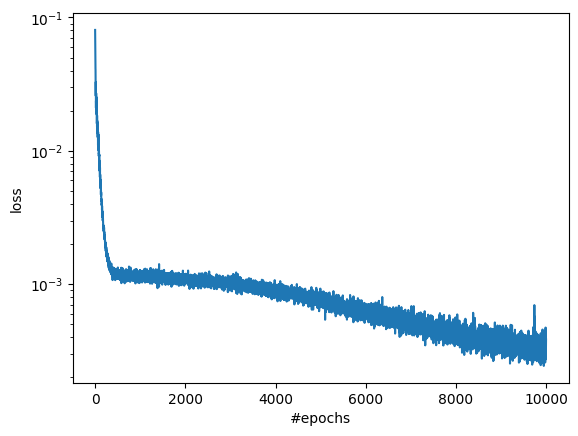

In [ ]:
# Number of training epochs
N = 10000
# learning rate
learning_rate = 1e-4

optim = keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(model, t):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = loss_grad(model, t)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

hist = []
for i in range(N):
    t = tf.random.uniform([64, 1], 0, tmax)
    loss = train_step(model, t)

    # Append current loss to hist
    hist.append(loss.numpy())

    if i%500 == 0:
      print('Epoch:',i,' loss: {}'.format(hist[-1]))

# Print the loss
print('Epoch:',i,' loss: {}'.format(hist[-1]))

# Print the learning curve
plt.semilogy(range(len(hist)), np.array(hist).flatten())
plt.xlabel('#epochs')
plt.ylabel('loss');

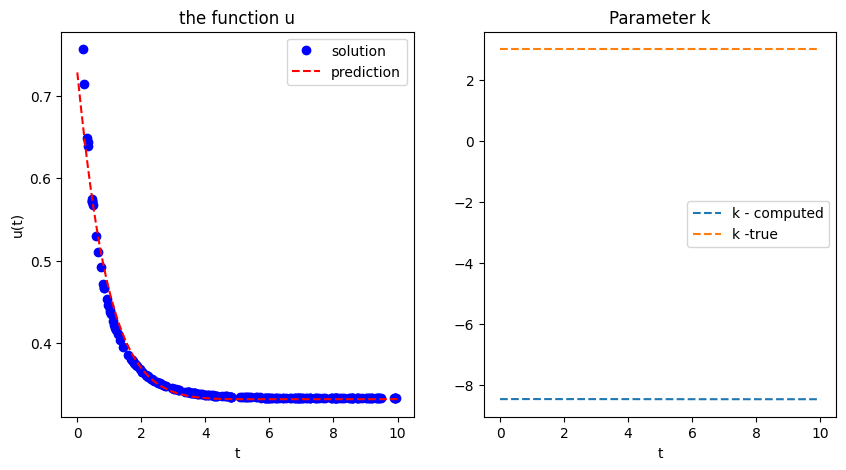

In [ ]:
t = np.linspace(0, tmax, 1000)
u = model(t.reshape(1000, 1)).numpy()
fig, axs = plt.subplots(1, 2,figsize=(10,5))

axs[0].plot(t_params, u_params, 'bo', label="solution")
axs[0].plot(t, u[:,0], "r--", label="prediction")
axs[0].set_title("the function u")
axs[0].set_xlabel("t")
axs[0].set_ylabel("u(t)")
axs[0].legend()

#Uncomment below if you found r instead of k
#axs[1].plot(t, u[:,1], "--", label="r - computed")
#axs[1].plot(t, r_star*np.ones(len(t)), "--", label="r -true")
axs[1].plot(t, u[:,2], "--", label="k - computed")
axs[1].plot(t, k_star*np.ones(len(t)), "--", label="k -true")
axs[1].legend()
axs[1].set_title("Parameter k")
axs[1].set_xlabel("t")
plt.show()

### Question

Change the code in the function `logistic_residue` to learn $r$ instead, assuming that $k=k^*$ is known.


In [ ]:
# @title Answer
def logistic_residue(V, V_t):
    u, r, k = V[:,:1], V[:,1:2], V[:,2:]
    u_t = V_t[:,0:1]
    r_t = V_t[:,1:2]
    k_t = V_t[:,2:3]
    return (u_t - r*u*(1 - k_star*u))**2 + r_t**2

### Question
Assume both $r$ and $k$ are unknown. Change the code in the function `logistic_residue` to learn $r$ and $k$.

In [ ]:
# @title Answer
def logistic_residue(V, V_t):
    u, r, k = V[:,:1], V[:,1:2], V[:,2:]
    u_t = V_t[:,0:1]
    r_t = V_t[:,1:2]
    k_t = V_t[:,2:3]
    return (u_t - r*u*(1 - k*u))**2 + r_t**2 + k_t**2

Rerun the model after this change. Does the model learn the correct values of $r$ and $k$?

# Helmholtz equation
Let us now solve a problem that is difficult to solve using standard numerical methods, but it is fairly straightforward to solve in PINNs. We will solve Helmholtz equation with an unknown parameter, and determine this parameter by PINNs methods.

$$ u_{xx}+u_{yy} + k^2 u = -k^2\sin(k x)\sin(k y), \qquad  \Omega = (0,1)\times (0,1),$$
with the Dirichlet boundary conditions $$u(x,y)=0, \qquad (x,y)\in \partial \Omega.$$

We will take $k = \pi$. For that value of $k$, the exact solution is
 $$u(x,y)= \sin(k x)\sin(k y).$$

In [ ]:
k_star = np.pi

In [ ]:
def Helm_sol(z):
    return np.sin(k_star*z[:,0:1])*np.sin(k_star*z[:,1:2])

def params_data(nbr_pts=100):
    z = np.random.uniform(0, 1, [nbr_pts, 2])
    return z, Helm_sol(z)

In [ ]:
k = tf.Variable(2.)
def Helm_residue(z, u, u_xx, u_yy):
    # z = (x, y)
    f = k**2 * tf.sin(k*z[:,0:1])*tf.sin(k*z[:,1:2])
    return  (f + u_xx + u_yy + k**2 * u)**2

In [ ]:
def get_derivatives(model, z):

    with tf.GradientTape(persistent=True) as tape:

        x = z[:,0:1]
        y = z[:,1:2]
        tape.watch(x)
        tape.watch(y)
        u = model(tf.concat([x, y], -1))

        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
        # k_x = tape.gradient(k, x)
        # k_y = tape.gradient(k, y)

    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)

    del tape

    return z, u, u_xx, u_yy

In [ ]:
z_params, u_params = params_data(10)

def loss_fn(model, X_int, X_bc):
    X_int, u, u_xx, u_yy = get_derivatives(model, X_int)
    res = Helm_residue(X_int, u, u_xx, u_yy)
    loss_res = tf.reduce_mean(res)

    loss_bc = tf.reduce_mean((model(X_bc))**2)
    loss_param = tf.reduce_mean((model(z_params) - u_params)**2)

    return loss_res + loss_bc + loss_param

In [ ]:
def loss_grad(model, X_int, X_bc):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = loss_fn(model, X_int, X_bc)
    grad_theta = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, grad_theta

In [ ]:
def batch_generator(int_batch_size=64, bc_batch_size=32):
    #==================================
    #points for the boundary condition
    #==================================
    n = bc_batch_size // 2
    a = tf.random.uniform([n], 0, 2, dtype=tf.int32)
    a = tf.cast(a, tf.float32)
    b = tf.random.uniform([n], 0, 1)
    X_bc0 = tf.concat([a, b], -1)

    c = tf.random.uniform([n], 0, 2, dtype=tf.int32)
    c = tf.cast(c, tf.float32)
    d = tf.random.uniform([n], 0, 1)
    X_bc1 = tf.concat([d, c], -1)

    X_bc = tf.stack([X_bc0, X_bc1], 1)
    #==================================
    #interior points
    #==================================
    X_int0 = tf.random.uniform((int_batch_size,1), 0, 1)
    X_int1 = tf.random.uniform((int_batch_size,1), 0., 1)
    X_int = tf.concat([X_int0, X_int1], -1)
    return X_int, X_bc

In [ ]:
class Helm_model(PINN_model):
    def __init__(self, parameter, **kwargs):
        super().__init__(**kwargs)
        self.parameter=parameter

model = Helm_model(
    parameter=k,
    output_dim=1,
    num_layers=4,
    size_layer=64,
    activation=tf.keras.activations.get(tf.math.sin),
    )
model.build(input_shape=(None,2))

Epoch 0 loss: 3.7360191 , k: 1.9999
Epoch 500 loss: 0.18452421 , k: 1.9693848
Epoch 1000 loss: 0.14024118 , k: 1.96294
Epoch 1500 loss: 0.13157123 , k: 1.9566597
Epoch 2000 loss: 0.12212842 , k: 1.950104
Epoch 2500 loss: 0.10195488 , k: 1.9461467
Epoch 3000 loss: 0.08845587 , k: 1.9505689
Epoch 3500 loss: 0.083870485 , k: 1.9589654
Epoch 4000 loss: 0.076906584 , k: 1.9737401
Epoch 4500 loss: 0.07101414 , k: 1.9994456
Epoch 5000 loss: 0.06725645 , k: 2.032243
Epoch 5500 loss: 0.063729614 , k: 2.0689132
Epoch 6000 loss: 0.06021559 , k: 2.1081808
Epoch 6500 loss: 0.05671594 , k: 2.1489823
Epoch 7000 loss: 0.05294705 , k: 2.19061
Epoch 7500 loss: 0.04931204 , k: 2.2327218
Epoch 8000 loss: 0.045890495 , k: 2.2744253
Epoch 8500 loss: 0.042617027 , k: 2.315735
Epoch 9000 loss: 0.03910989 , k: 2.3564403
Epoch 9500 loss: 0.03573964 , k: 2.3969653
Epoch 10000 loss: 0.032479603 , k: 2.437053
Epoch 10500 loss: 0.029374395 , k: 2.4765043
Epoch 11000 loss: 0.02644173 , k: 2.5151045
Epoch 11500 loss:

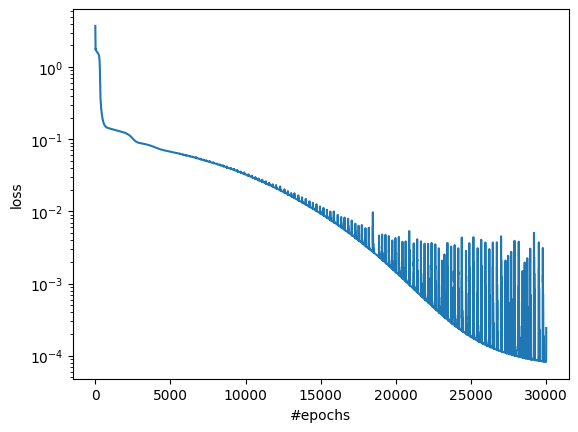

In [ ]:
# Number of training epochs
N = 30000
# learning rate
learning_rate = 1e-4

int_batch_size=500
bc_batch_size=200

X_int, X_bc = batch_generator(int_batch_size, bc_batch_size)

optim = keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(model, X_int, X_bc):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = loss_grad(model, X_int, X_bc)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

hist = []
for i in range(N):
    loss = train_step(model, X_int, X_bc)

    # Append current loss to hist
    hist.append(loss.numpy())

    if i%500 == 0:
      print('Epoch',i,"loss:", loss.numpy(),",","k:", model.parameter.numpy())

# Print the learning curve
plt.semilogy(range(len(hist)), np.array(hist).flatten())
plt.xlabel('#epochs')
plt.ylabel('loss');

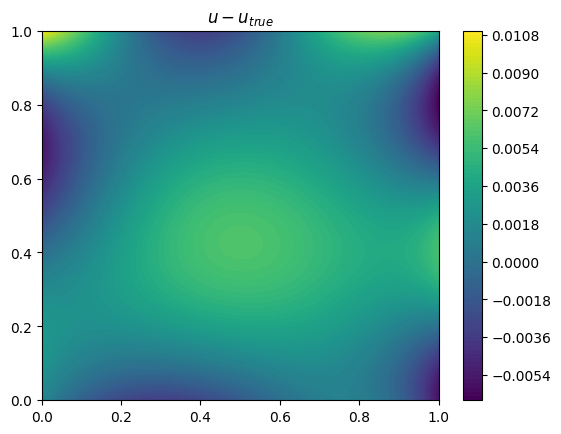

In [ ]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z_pred = model(np.stack([X.flatten(), Y.flatten()], 1)).numpy()[:,0:1].reshape(100, 100)
Z_true = np.sin(k_star*X)*np.sin(k_star*Y)
plt.contourf(X, Y, Z_true - Z_pred, cmap="viridis", levels=100)
plt.title(r'$u - u_{true}$')
plt.colorbar()
plt.show()

In [ ]:
print("Computed k:",model.parameter.numpy(), " True value:",k_star)

Computed k: 3.1326408  True value: 3.141592653589793


#Parametric differential equations

We use the following example to   show that given a small set of data points one can learn parametric solutions, i.e. solutions that depend on a given parameter.

Consider the parameteric differential equation with parameter $\omega$
$$\frac{d^2u(x)}{dx^2} + \omega^2 u(x)=0,$$
and initial conditions $u(0)=1, u'(0)=0$.


The exact solution to the above equation is $u_\omega(x) =\cos(\omega x)$. (Here we use the notation $u_\omega$ just to emphasize the fact the solution $u$ depends on $\omega$. The notation should not mean derivative with respect to $\omega$). The goal of this example is to learn the solution $u_\omega(x)$, depending on $\omega$, for $\omega\in[\omega_0, \omega_1]$, knowing data points from the solutions $u_{\omega_0}$ and $u_{\omega_1}$.

We use the following functions to generate data points from the solutions $u_{\omega_0}(x)$ and $u_{\omega_0}(x)$, which happen to be, respectively, $\cos(\omega_0 x)$ and $\cos(\omega_1 x)$, in this case.

In [ ]:
omega0 = 0
omega1 = np.pi

def func_omega0(x):
    return tf.cos(omega0*x)

def func_omega1(x):
    return tf.cos(omega1*x)

A function that computes the residuals

In [ ]:
def residue(z, u, u_xx):
    omega = z[:,1:2]
    return  (u_xx + omega**2 * u)**2

A function that computes the required derivatives, namely, $\frac{du_{\omega}}{dx}(0), \frac{d^2 u_\omega}{dx^2}(x)$, and the evalutes $u_\omega(0)$.

In [ ]:
def get_derivatives(model, X_int, X_IC):
    with tf.GradientTape(persistent=True) as tape:

        x = X_int[:,0:1]
        omega = X_int[:,1:2]
        tape.watch(x)
        tape.watch(X_IC)
        u = model(tf.concat([x, omega], -1))
        u0 = model(X_IC)
        u_x = tape.gradient(u, x)
        u_x0 = tape.gradient(u0, X_IC)[0]
    u_xx = tape.gradient(u_x, x)
    del tape

    return X_int, u, u0, u_x0, u_xx

A function that computes the different losses

In [ ]:
def loss_fn(model, X_int, X_IC, X_bc0, X_bc1):
    X_int, u, u0, u_x0, u_xx = get_derivatives(model, X_int, X_IC)
    res = residue(X_int, u, u_xx)
    loss_res = tf.reduce_mean(res)

    loss_ic = tf.reduce_mean((u0 - 1)**2 + u_x0**2)

    loss_bc = tf.reduce_mean((model(X_bc0) - func_omega0(X_bc0[:,0:1]))**2)
    loss_bc += tf.reduce_mean((model(X_bc1) - func_omega1(X_bc1[:,0:1]))**2)

    return loss_res + loss_ic + loss_bc

In [ ]:
def loss_grad(model, X_int, X_IC, X_bc0, X_bc1):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = loss_fn(model, X_int, X_IC, X_bc0, X_bc1)
    grad_theta = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, grad_theta

In [ ]:
def batch_generator(int_batch_size=64, ic_batch_size=32, bc_batch_size=32):
    #==================================
    #points for the boundary condition
    #==================================
    X_bc0 = tf.stack([tf.random.uniform([bc_batch_size], 0, np.pi), [omega0]*bc_batch_size], 1)

    X_bc1 = tf.stack([tf.random.uniform([bc_batch_size], 0, np.pi), [omega1]*bc_batch_size], 1)
    #==================================
    #interior points
    #==================================
    X_int0 = tf.random.uniform([int_batch_size], 0, np.pi)
    X_int1 = tf.random.uniform([int_batch_size], omega0, omega1)
    X_int = tf.stack([X_int0, X_int1], 1)
    #==================================
    #IC points
    #==================================
    X_IC0 = tf.zeros([ic_batch_size])
    X_IC1 = tf.random.uniform([ic_batch_size], omega0, omega1)
    X_IC = tf.stack([X_IC0, X_IC1], 1)

    return X_int, X_IC, X_bc0, X_bc1

Define the model

In [ ]:
class build_model(PINN_model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

model = build_model(
    output_dim=1,
    num_layers=4,
    size_layer=64,
    activation="tanh",
    )
model.build(input_shape=(None,2))

The data points used for training are stored in `X_bc0` and `X_bc1`. `X_bc0` contains the observations for $\omega_0$ and `X_bc1` contains the observations for $\omega_1$.


In [ ]:
X_int, X_IC, X_bc0, X_bc1 = batch_generator(500, 100, 100)

Of course, `X_bc0` and `X_bc1` should be changed during training, but the residual and the IC points `X_int` and `X_IC`can. However in this example we use fixed sets `X_int` and `X_IC`. Both `X_bc0` and `X_bc1` contain $100$ points.

Epoch 0 loss: 3.2204852
Epoch 1000 loss: 1.0383142
Epoch 2000 loss: 0.7626449
Epoch 3000 loss: 0.2731393
Epoch 4000 loss: 0.055218782
Epoch 5000 loss: 0.008681748
Epoch 6000 loss: 0.0039174897
Epoch 7000 loss: 0.002064358
Epoch 8000 loss: 0.0010959227
Epoch 9000 loss: 0.000588298


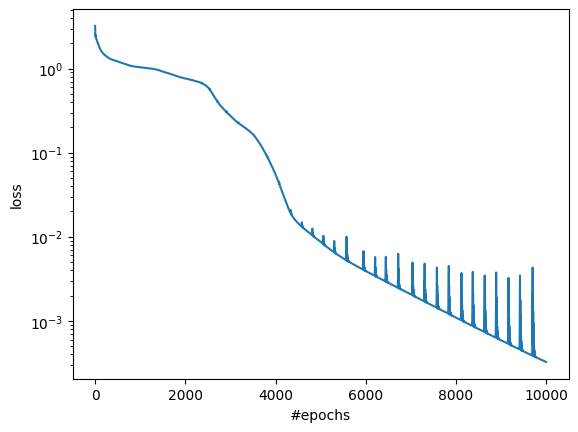

In [ ]:
# Number of training epochs
N = 10000
# learning rate
learning_rate = 1e-4


optim = keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(model, X_int, X_IC, X_bc0, X_bc1):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = loss_grad(model, X_int, X_IC, X_bc0, X_bc1)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

hist = []
for i in range(N):
    loss = train_step(model, X_int, X_IC, X_bc0, X_bc1)
    hist.append(loss.numpy())

    if i%1000 == 0:
      print('Epoch',i,"loss:", loss.numpy())

# Print the learning curve
plt.semilogy(range(len(hist)), np.array(hist))
plt.xlabel('#epochs')
plt.ylabel('loss');

Let's compare the predicted solutions $u_\omega$ with the exact solutions for differents values of $\omega \in [\omega_0,\omega_1]$.

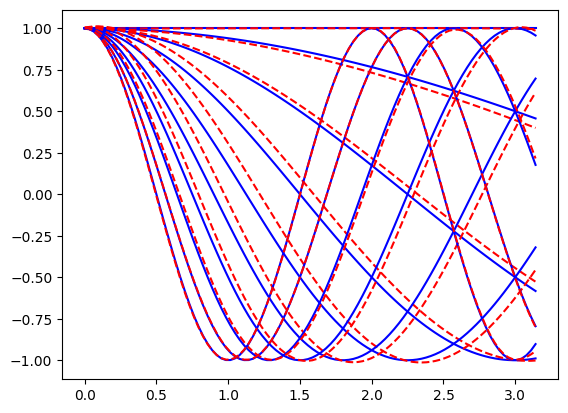

In [ ]:
x = np.linspace(0, np.pi, 100)
Omega = np.linspace(omega0, omega1, 10)
for omega in Omega:
    y = model(np.stack([x, [omega]*100], 1))
    plt.plot(x, np.cos(omega*x),'b-')
    plt.plot(x, y, "r--")
plt.show()